In [26]:
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import pollock.utils as utils
import pollock.explain as explain

If you haven't already done so, you can download pretrained models from https://zenodo.org/record/5895221

In [5]:
# !wget https://zenodo.org/record/5895221/files/pretrained_models.tar.gz?download=1
# !tar -xf 'pretrained_models.tar.gz?download=1'

for this example, we will use the general scRNA-seq model

In [8]:
model_filepath = 'pretrained_models/scRNAseq_generalized/'

If you haven't yet, download example pbmc dataset

In [9]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [33]:
count_adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols')
count_adata.var_names_make_unique()

here we load the same anndata object we created in examples/pbmc_model_training_and_prediction.ipynb and use it to populate manually annotated cell types for the raw pbmc count dataset. if you haven't ran that example you can comment this step, you just wont be able to run some of the cells later in the notebook that compare the predicted annotations to the manual annotations.

In [34]:
processed_adata = sc.read_h5ad('data/pbmc.h5ad')
count_adata = count_adata[processed_adata.obs.index]
count_adata.obs['cell_type'] = processed_adata.obs['cell_type'].to_list()
count_adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'cell_type'
    var: 'gene_ids'

## Cell type prediction

load model

In [35]:
model = utils.load_model(model_filepath)

In [36]:
# possible cell type predictions
model.classes

['Acinar',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Erythrocyte',
 'Fibroblast',
 'Islet',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Platlete',
 'Treg',
 'Tuft']

predict cell types

In [37]:
# note that if you are predicting a large dataset and don't need the pollock umap embeddings you can set make_umap to False to increase runtime speed
adata = utils.predict_adata(model, count_adata, make_umap=True)
adata

2022-01-24 09:47:13,449 12679 genes overlap with model after filtering
2022-01-24 09:47:13,450 4859 genes missing from dataset after filtering
2022-01-24 09:47:14,493 starting prediction of 2638 cells


AnnData object with n_obs × n_vars = 2638 × 17538
    obs: 'cell_type', 'n_counts', 'size_factors', 'y_pred', 'predicted_cell_type_probability', 'predicted_cell_type', 'probability Acinar', 'probability B cell', 'probability CD4 T cell', 'probability CD8 T cell', 'probability Dendritic', 'probability Endothelial', 'probability Erythrocyte', 'probability Fibroblast', 'probability Islet', 'probability Malignant', 'probability Mast', 'probability Monocyte', 'probability NK', 'probability Plasma', 'probability Platlete', 'probability Treg', 'probability Tuft'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_emb', 'X_umap', 'prediction_probs'

In [38]:
adata.obs

,cell_type,n_counts,size_factors,y_pred,predicted_cell_type_probability,predicted_cell_type,probability Acinar,probability B cell,probability CD4 T cell,probability CD8 T cell,...,probability Fibroblast,probability Islet,probability Malignant,probability Mast,probability Monocyte,probability NK,probability Plasma,probability Platlete,probability Treg,probability Tuft
AAACATACAACCAC-1,CD8 T,2259.0,1.088937,2,0.339878,CD4 T cell,0.049298,0.016812,0.339878,0.276915,...,0.035055,0.039081,0.031491,0.010566,0.032301,0.015278,0.021905,0.007729,0.024242,0.014640
AAACATTGAGCTAC-1,B,4561.0,2.198602,1,0.980307,B cell,0.000241,0.980307,0.000764,0.000367,...,0.001447,0.000707,0.001249,0.002175,0.000456,0.000965,0.002259,0.000550,0.001350,0.000690
AAACATTGATCAGC-1,CD4 T,2995.0,1.443721,15,0.303968,Treg,0.020321,0.043927,0.064743,0.110785,...,0.031480,0.020701,0.015346,0.081746,0.042202,0.060592,0.049396,0.015010,0.303968,0.026532
AAACCGTGCTTCCG-1,FCGR3A Monocytes,2491.0,1.200771,11,0.981028,Monocyte,0.002669,0.000858,0.001171,0.002138,...,0.000114,0.000416,0.001976,0.000158,0.981028,0.000555,0.000535,0.000337,0.002223,0.000684
AAACCGTGTATGCG-1,NK,920.0,0.443480,12,0.889776,NK,0.000365,0.002328,0.020445,0.050069,...,0.000327,0.005088,0.006473,0.002751,0.002869,0.889776,0.011660,0.000903,0.001890,0.001235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,CD14 Monocytes,3257.0,1.570017,11,0.975905,Monocyte,0.001545,0.000588,0.000973,0.001565,...,0.000161,0.000238,0.001450,0.000238,0.975905,0.000994,0.001301,0.000342,0.000967,0.000678
TTTCTACTGAGGCA-1,B,3248.0,1.565678,13,0.629583,Plasma,0.000435,0.015639,0.002604,0.005545,...,0.011590,0.000468,0.245941,0.032722,0.008847,0.011580,0.629583,0.002008,0.001602,0.004431
TTTCTACTTCCTCG-1,B,1581.0,0.762111,1,0.914001,B cell,0.000812,0.914001,0.001059,0.002118,...,0.006497,0.001146,0.011024,0.004892,0.000996,0.001586,0.022407,0.001326,0.001775,0.001933
TTTGCATGAGAGGC-1,B,956.0,0.460834,1,0.835800,B cell,0.005579,0.835800,0.008617,0.007995,...,0.009277,0.008273,0.012723,0.016938,0.003926,0.011355,0.014209,0.004986,0.005910,0.005747


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


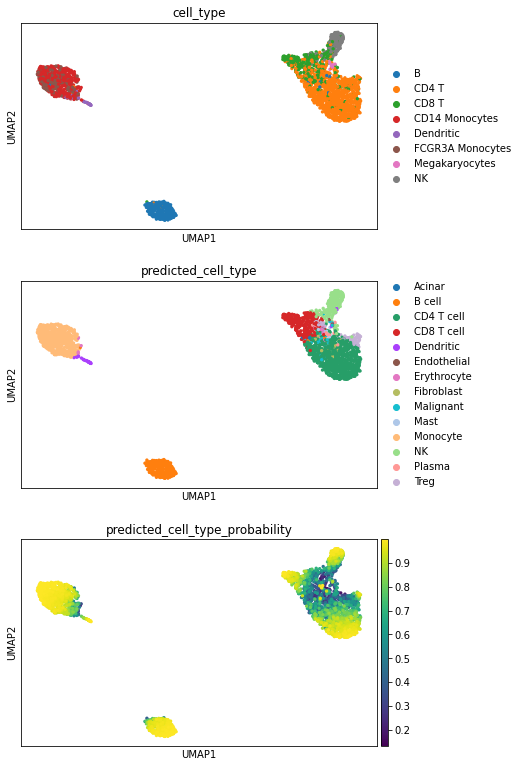

In [39]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability'], ncols=1)

In [40]:
def get_metrics(y_true_labels, y_pred_labels):
    classes = sorted(set(y_true_labels).union(set(y_pred_labels)))

    y_pred = [classes.index(c) for c in y_pred_labels]
    y_true = [classes.index(c) for c in y_true_labels]

    clf_report = classification_report(y_true, y_pred, labels=list(range(len(classes))), target_names=classes,
                             output_dict=True)
    clf_report = pd.DataFrame.from_dict(clf_report)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm = pd.DataFrame(data=cm, index=classes, columns=classes)
    
    clf_report.index.name = 'metric'
    cm.index.name = 'cell_type'
    
    return clf_report, cm

In [41]:
# using only validation anndata to look at performance metrics
y_pred = adata.obs['predicted_cell_type'].to_list()
y_true = adata.obs['cell_type'].to_list()
clf_report, cm = get_metrics(y_true, y_pred)
cm = cm.loc[sorted(set(adata.obs['cell_type'])), sorted(set(adata.obs['predicted_cell_type']))]

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

Text(32.99999999999999, 0.5, 'manual annotation')

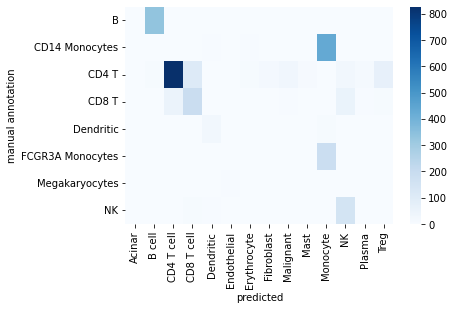

In [42]:
sns.heatmap(cm, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

In [43]:
# wonky because manual annotations and possible predicted cell type labels aren't the same
clf_report

,Acinar,B,B cell,CD14 Monocytes,CD4 T,CD4 T cell,CD8 T,CD8 T cell,Dendritic,Endothelial,...,Malignant,Mast,Megakaryocytes,Monocyte,NK,Plasma,Treg,accuracy,macro avg,weighted avg
metric,,,,,,,,,,,,,,,,,,,,,
precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642857,0.0,...,0.0,0.0,0.0,0.0,0.645299,0.0,0.0,0.067475,0.064408,0.048890
recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,...,0.0,0.0,0.0,0.0,0.920732,0.0,0.0,0.067475,0.083537,0.067475
f1-score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.692308,0.0,...,0.0,0.0,0.0,0.0,0.758794,0.0,0.0,0.067475,0.072555,0.056621
support,0.0,342.0,0.0,445.0,1127.0,0.0,320.0,0.0,36.000000,0.0,...,0.0,0.0,13.0,0.0,164.000000,0.0,0.0,0.067475,2638.000000,2638.000000


## Explain model predictions

we randomly select 100 cells from each cell type to explain, and 10 cells from each cell type as background expression profiles

In [78]:
# get explain ids
explain_ids, remaining_ids = utils.get_splits(adata, 'predicted_cell_type', n_per_cell_type=500,
                                            oversample=False, split=.8)

# get validation ids from remaining ids. here we take min(num cells remaining, 100) cells for each cell type.
background_ids, _ = utils.get_splits(adata[remaining_ids], 'predicted_cell_type', n_per_cell_type=100,
                              oversample=False, split=1.)

count_adata.obs['predicted_cell_type'] = adata[count_adata.obs.index].obs['predicted_cell_type'].to_list()

explain_adata, background_adata = count_adata[explain_ids], count_adata[background_ids]
explain_adata.shape, background_adata.shape

((1899, 16579), (429, 16579))

In [79]:
Counter(adata[explain_ids].obs['predicted_cell_type']).most_common()

[('CD4 T cell', 500),
 ('Monocyte', 500),
 ('B cell', 275),
 ('CD8 T cell', 244),
 ('NK', 187),
 ('Treg', 64),
 ('Dendritic', 33),
 ('Malignant', 32),
 ('Plasma', 18),
 ('Fibroblast', 16),
 ('Erythrocyte', 14),
 ('Mast', 10),
 ('Endothelial', 4),
 ('Acinar', 2)]

In [80]:
Counter(adata[background_ids].obs['predicted_cell_type']).most_common()

[('CD4 T cell', 100),
 ('Monocyte', 100),
 ('B cell', 69),
 ('CD8 T cell', 61),
 ('NK', 47),
 ('Treg', 16),
 ('Dendritic', 9),
 ('Malignant', 8),
 ('Plasma', 5),
 ('Fibroblast', 5),
 ('Erythrocyte', 4),
 ('Mast', 3),
 ('Endothelial', 1),
 ('Acinar', 1)]

we have very small numbers of some random cell types (like acinar cells) that clearly aren't pbmc cells types. but we'll leave them alone for now

In [81]:
from importlib import reload
reload(explain)

<module 'pollock.explain' from '/home/estorrs/pollock/pollock/explain.py'>

In [82]:
score_df = explain.explain_predictions(model, explain_adata, background_adata, label_key='predicted_cell_type')
score_df

2022-01-24 10:17:04,399 calculating feature scores for Acinar
Trying to set attribute `.var` of view, copying.
2022-01-24 10:17:04,419 1002 genes overlap with model after filtering
2022-01-24 10:17:04,420 16536 genes missing from dataset after filtering
Trying to set attribute `.var` of view, copying.
2022-01-24 10:17:04,492 10991 genes overlap with model after filtering
2022-01-24 10:17:04,493 6547 genes missing from dataset after filtering
2022-01-24 10:17:04,783 calculating feature scores for B cell
Trying to set attribute `.var` of view, copying.
2022-01-24 10:17:04,805 9701 genes overlap with model after filtering
2022-01-24 10:17:04,805 7837 genes missing from dataset after filtering
2022-01-24 10:17:04,963 10991 genes overlap with model after filtering
2022-01-24 10:17:04,964 6547 genes missing from dataset after filtering
2022-01-24 10:17:09,097 calculating feature scores for CD4 T cell
Trying to set attribute `.var` of view, copying.
2022-01-24 10:17:09,124 10708 genes overlap

,AL627309.1,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,...,TP53TG3D,PKD1L3,OR4D1,AC022960.1,GNAS-AS1,CSNK1G2-AS1,LINGO3,TEX101,ZNF534,predicted_cell_type
AGACGTACCCCTAC-1,1.585929e-13,2.424226e-13,2.523291e-12,0.000000,0.0,3.127803e-13,1.677329e-12,1.818815e-13,1.116210e-12,1.594769e-12,...,9.537113e-14,0.0,0.0,0.0,0.0,0.0,8.221892e-13,0.0,0.0,Acinar
GTAATAACGTTGTG-1,2.394798e-12,2.587161e-13,1.770697e-13,0.000000,0.0,2.996192e-12,3.122055e-12,8.912078e-13,2.741540e-12,1.781642e-12,...,3.009396e-13,0.0,0.0,0.0,0.0,0.0,4.039163e-14,0.0,0.0,Acinar
GACTACGATGGTCA-1,1.844191e-12,4.302024e-13,2.245398e-05,0.000014,0.0,2.517936e-06,2.019889e-05,1.150406e-13,3.125933e-05,1.785508e-05,...,3.495924e-12,0.0,0.0,0.0,0.0,0.0,9.471485e-13,0.0,0.0,B cell
GTTAGGTGGAACTC-1,4.208049e-12,4.376841e-13,3.451465e-05,0.000018,0.0,2.757419e-05,1.769989e-05,4.264727e-13,2.311926e-05,4.174871e-04,...,8.888992e-12,0.0,0.0,0.0,0.0,0.0,2.377464e-12,0.0,0.0,B cell
ACGCGGTGTGTGGT-1,1.048022e-12,7.258679e-14,4.106127e-06,0.000013,0.0,6.741345e-06,6.252054e-07,3.209678e-14,2.795264e-05,1.087273e-04,...,9.377205e-13,0.0,0.0,0.0,0.0,0.0,9.928193e-13,0.0,0.0,B cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACCATTACGAGATA-1,3.677320e-13,1.796952e-13,2.131665e-05,0.000000,0.0,1.348781e-03,3.168081e-12,4.978485e-13,1.515340e-12,4.433102e-04,...,6.637015e-12,0.0,0.0,0.0,0.0,0.0,7.629533e-06,0.0,0.0,Treg
TACAATGACTTAGG-1,2.971528e-13,3.786451e-13,6.668616e-05,0.000000,0.0,6.430752e-05,3.230611e-12,5.766854e-13,1.422714e-12,1.482747e-04,...,3.788960e-13,0.0,0.0,0.0,0.0,0.0,5.613582e-05,0.0,0.0,Treg
TTAACCACCGTAAC-1,1.361471e-12,8.685793e-13,5.364223e-05,0.000000,0.0,9.216205e-05,6.165623e-12,5.572976e-13,2.831570e-13,1.073648e-04,...,8.100451e-12,0.0,0.0,0.0,0.0,0.0,2.509547e-05,0.0,0.0,Treg
ATAGCGTGTCTCTA-1,2.360343e-12,1.478057e-13,7.480903e-05,0.000000,0.0,1.740775e-04,1.286242e-11,1.002137e-12,3.782527e-12,1.685409e-04,...,8.874831e-12,0.0,0.0,0.0,0.0,0.0,4.660054e-05,0.0,0.0,Treg


visualizing known markers

In [83]:
# constructing weights as an AnnData object so we can use anndata/scanpy plotting functionality
feature_adata = anndata.AnnData(X=score_df.values[:, :-1],
                       obs=explain_adata[score_df.index].obs)
feature_adata.var.index = score_df.columns[:-1]
feature_adata

AnnData object with n_obs × n_vars = 1899 × 17538
    obs: 'cell_type', 'n_counts', 'predicted_cell_type'

In [104]:
markers = {
    'NK': ['GNLY', 'NKG7'],
    'CD4 T cells': ['CD3D', 'IL7R'],
    'CD8 T cells': ['CD3D', 'CD8A'],
    'B-cell': ['CD79A', 'MS4A1'],
    'Monocytes/Macrophages': ['FCGR3A', 'CD14', 'ITGAM', 'LYZ'],
    'Dendritic': ['ITGAX'],
    'Antigen presentation': ['HLA-DRA'],
    'Treg': ['FOXP3'],
}

Here we run scanpy's DEG workflow to see what features are differentially weighted among the different cell types

In [85]:
sc.pp.scale(feature_adata)
feature_adata

AnnData object with n_obs × n_vars = 1899 × 17538
    obs: 'cell_type', 'n_counts', 'predicted_cell_type'
    var: 'mean', 'std'

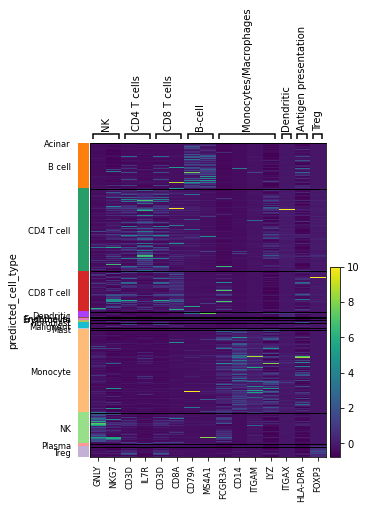

In [105]:
sc.pl.heatmap(feature_adata, var_names=markers, groupby='predicted_cell_type', vmax=10.)

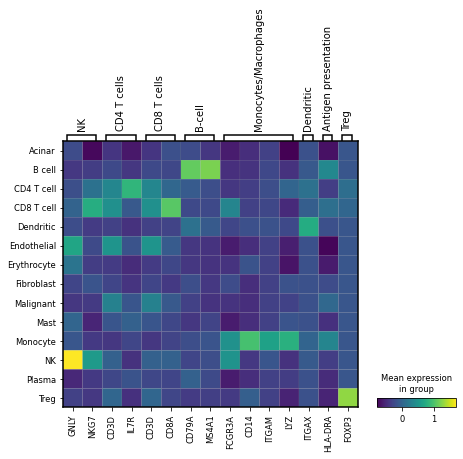

In [106]:
sc.pl.matrixplot(feature_adata, var_names=markers, groupby='predicted_cell_type')

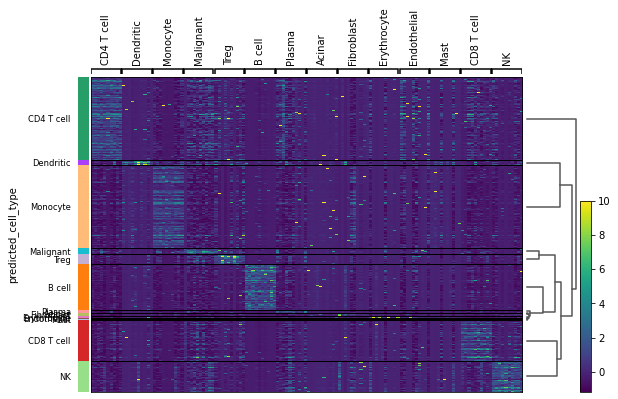

In [108]:
sc.tl.rank_genes_groups(feature_adata, groupby='predicted_cell_type')
sc.pl.rank_genes_groups_heatmap(feature_adata, vmax=10.)

Viewing specific groups of cells

categories: Acinar, B cell, CD4 T cell, etc.
var_group_labels: B cell, Monocyte


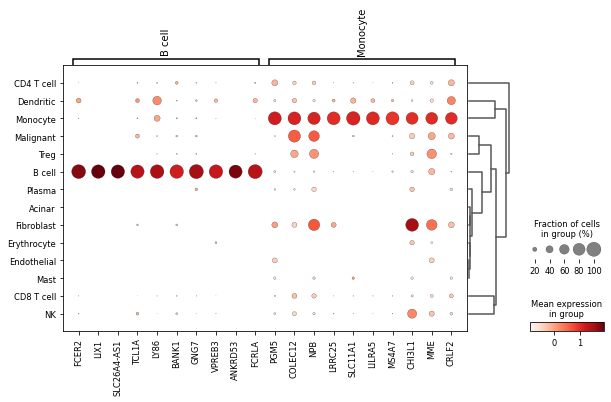

In [110]:
sc.pl.rank_genes_groups_dotplot(feature_adata, groups=['B cell', 'Monocyte'])